## Classificação dos textos dos twitters usando Bi-LSTM com Keras

In [1]:
#Import
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import layers
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.__version__

'2.7.0'

In [4]:
#Loading dataset
path = "dataset_sidi_512.csv"
df512 = pd.read_csv(path, sep='\t')
df512

,Unnamed: 0,Unnamed: 0.1,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width
0,382583,382583,798338609870872577-2,0.774375,0.174701,0.050924,what does it look like i do for a living? (cra...,NEG,0,data/79833/798338609870872577-2.jpg,1280,722
1,443004,443004,802556641057054721-1,0.540009,0.304103,0.155888,No cheat just skill. #ClikerHeroes https://t.c...,NEG,0,data/80255/802556641057054721-1.jpg,707,1366
2,348885,348885,796032212407721984-1,0.513661,0.322456,0.163883,@KEILOin_DaTrunk I deleted https://t.co/qIhBkn...,NEG,0,data/79603/796032212407721984-1.jpg,1334,750
3,377487,377487,798011160532381696-1,0.712648,0.254173,0.033180,"""RT NYTFashion: How Nasty Gal went from an eBa...",NEG,0,data/79801/798011160532381696-1.jpg,561,1000
4,423703,423703,801181521679790080-1,0.713677,0.186854,0.099468,I hate this nigga lmaooo https://t.co/gPcyJfJESN,NEG,0,data/80118/801181521679790080-1.jpg,1334,750
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,108284,108284,769551952275509248-1,0.010517,0.886504,0.102978,RT @Alwas97: find someone who loves you like b...,NEU,1,data/76955/769551952275509248-1.jpg,1218,1078
11996,93186,93186,769486781158858753-1,0.065240,0.897818,0.036942,RT @MelbWritersFest: Helen Garner talking to @...,NEU,1,data/76948/769486781158858753-1.jpg,1491,2048
11997,298145,298145,783915769943973890-1,0.011468,0.925276,0.063257,Watch lesbian movie: https://t.co/jzJrDcnAwaSh...,NEU,1,data/78391/783915769943973890-1.jpg,1024,683
11998,260672,260672,783138720610476033-1,0.003072,0.957911,0.039016,Click here to watch the movie: https://t.co/A...,NEU,1,data/78313/783138720610476033-1.jpg,1024,682


In [18]:
#tokenização
t  = Tokenizer()

filenames = df512['text'].tolist()
t.fit_on_texts(filenames)


labels = df512['sent_image'].tolist()

#holdout 80/10/10
#Separando treino e parte para validação e teste
x_train, x_split_two, y_train, y_split_two = train_test_split( t.texts_to_sequences(filenames),labels, train_size=0.8,random_state=42)
#Separando teste e validação
x_val, x_test, y_val, y_test = train_test_split(x_split_two,y_split_two, train_size=0.5,random_state=42)

In [19]:
#Mudando o formato para suporta o softmax na rede
#saindo do formato [2] para [0,0,1]
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [20]:
maxlen = 100
max_features = 10000
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [21]:
#Para limpar memória
tf.keras.backend.clear_session()
import gc
gc.collect()

2506

In [22]:
#Arquitetura base da página https://keras.io/examples/nlp/bidirectional_lstm_imdb/
#Modificação feita na saida (3) e na acitivação da saida (solftmax)

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,478,019
Trainable params: 1,478,019
Non-train

In [23]:
#Compilando com lr de 0.001
model.compile(Adam(learning_rate=0.001), "categorical_crossentropy", metrics=["accuracy"])

#fazneodo early top quando o loss da validação aumentar
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

#treinando
model.fit(x_train, y_train, batch_size=300, epochs=20, validation_data=(x_val, y_val),callbacks=[es])

Epoch 1/20
32/32 [==============================] - 7s 82ms/step - loss: 1.0051 - accuracy: 0.4766 - val_loss: 0.8292 - val_accuracy: 0.6650
Epoch 2/20
32/32 [==============================] - 1s 36ms/step - loss: 0.4806 - accuracy: 0.8228 - val_loss: 0.3767 - val_accuracy: 0.8575
Epoch 3/20
32/32 [==============================] - 1s 33ms/step - loss: 0.1551 - accuracy: 0.9497 - val_loss: 0.3836 - val_accuracy: 0.8667
Epoch 00003: early stopping


### Resultados

In [24]:

y_pred = model.predict(x_test)
y_pred =(y_pred>0.5)
#list(y_pred)
print(accuracy_score(y_test, y_pred));
print(classification_report(y_test, y_pred));


0.8591666666666666
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       420
           1       0.83      0.84      0.84       374
           2       0.86      0.91      0.88       406

   micro avg       0.88      0.86      0.87      1200
   macro avg       0.88      0.86      0.87      1200
weighted avg       0.88      0.86      0.87      1200
 samples avg       0.86      0.86      0.86      1200



Negativo - 0     Neutro - 1      Positivo - 2


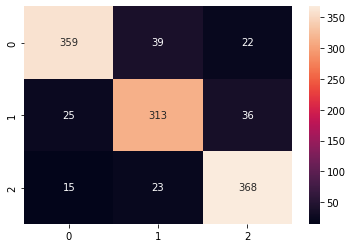

In [25]:
print("Negativo - 0     Neutro - 1      Positivo - 2")
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1),np.argmax(y_pred, axis=-1)), annot=True, fmt="d");

In [26]:
matrix = confusion_matrix(np.argmax(y_test, axis=-1),np.argmax(y_pred, axis=-1))
print("Negativo     Neutro     Positivo")
print(matrix.diagonal()/matrix.sum(axis=1))

Negativo     Neutro     Positivo
[0.8547619  0.8368984  0.90640394]
